get data from local database 

successfully connected to database
90065
('# of parcels updated in 2020: ', 108)
('# of parcels updated in 2021: ', 27)
('total # of parcels in table: ', 29700)


,ain,taxratearea,usecode,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft
0,5454027038,4,1100,1994,1994,779,65955.0,1987,27680,90065,34.095796,-118.228163,84.666239
1,6052030026,461,1100,1964,1964,1000,8339.0,1975,26631,90003,33.947870,-118.265508,8.339000
2,5359005001,1797,1100,1961,1961,612,61899.0,1975,27630,91801,34.078510,-118.118021,101.142157
3,4231018015,67,1100,1949,1949,621,31585.0,1975,25691,90066,33.996502,-118.428373,50.861514
4,4263011036,67,2500,1987,1987,975,1828489.0,2000,23687,90025,34.049304,-118.460372,1875.373333


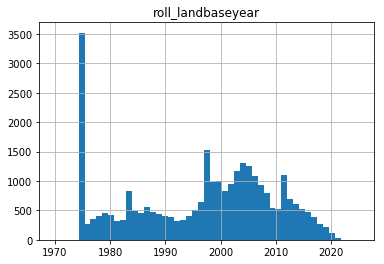

In [1]:
# %%time
import pandas as pd
import psycopg2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# read data from local psql database into pd dataframe
try:
    #conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
    #    "USER"), password=os.getenv("PASSWORD"))
    conn = psycopg2.connect(database='parceldatabase', user="newuser", password="password")
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "svr_table_2"', con=conn)

# print(df.head())
print(df.iloc[0].situszip5)

# taking out irrelevant columns and cols related to building/development on land. Usecode is relevant col but dropping
# b/c we can't parse it rn
# usecode - has letters too
drop_cols = ['istaxableparcel', 'usecodedescchar1', 'usecodedescchar2']

cat_cols = ['usecode']

df = df.drop(drop_cols, 1)

# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "taxratearea", 
                "center_lat", "cluster", "situszip5",
                "center_lon", "roll_landvalue", "sqftmain", 
                "effectiveyearbuilt", "yearbuilt"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

#  add land value per sqft column
df['landvalue_per_sqft'] = df['roll_landvalue'] / df['sqftmain']

# some basic visuals on distr of the land base year
df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))
df.head()


In [ ]:
# !pip install sklearn_pandas
!pip3 install -U sklearn_pandas

based on this reference: https://www.kaggle.com/gauthampughazh/house-sales-price-prediction-svr/notebook

In [2]:
%%time
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from IPython.display import FileLink
#from sklearn.cross_validation import train_test_split


CPU times: user 466 ms, sys: 479 ms, total: 945 ms
Wall time: 1.6 s


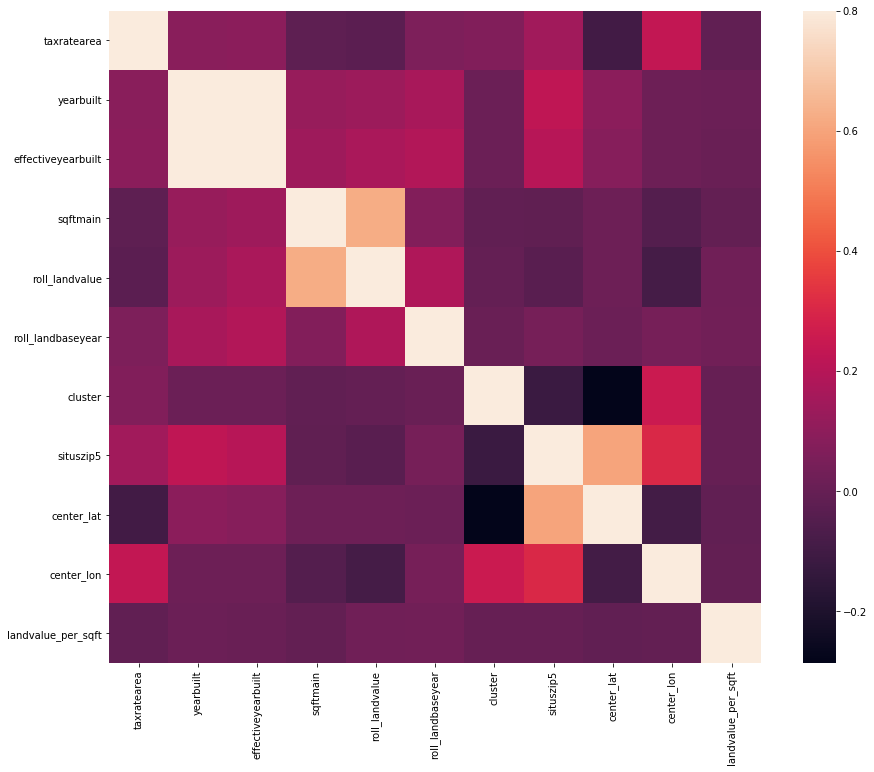

In [3]:

# split data into test and train
train_df, test_df = train_test_split(df, test_size=0.2)

# get correlation matrix
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()


In [4]:
# used to determine which columns were causing problems
import math
count = 0
for x in train_df['yearbuilt'].values:
    # NaN
    if pd.isna(x):
        count += 1
        print(x)
    # infinity
    if math.isinf(x):
        count += 1
    if x < 1800:
        count += 1
count

0

In [4]:
# Selecting only the numeric columns
train = train_df.select_dtypes(['int64', 'float64'])
test = test_df.select_dtypes(['int64', 'float64'])
# Dropping the insignificant features
#train = train.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars', 'Id'], axis=1)
#test = test.drop(['GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars', 'Id'], axis=1)
train.head()

,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft
20639,2530,1948,1948,1000,69390.0,1997,24632,91505,34.176962,-118.342504,69.390000
8618,5500,1964,1964,7348,905560.0,2004,26614,90814,33.771434,-118.165798,123.238977
9740,4173,1986,1986,2835,111924.0,1985,27609,91740,34.127814,-117.863469,39.479365
24174,13,1966,1966,13500,189128.0,1997,24653,91040,34.259124,-118.310648,14.009481
8905,14706,1989,1989,8529,1479406.0,1988,24627,91384,34.496947,-118.623457,173.455974


In [55]:
# Visualizing the unique value count in each feature
cat_count = train.apply(lambda x: x.value_counts().shape[0]).sort_values()
go.Figure(data=go.Bar(x=cat_count.index, y=cat_count))

In [5]:
# Extracting the SalePrice from training data
#Y_train = np.log(train['roll_landvalue'].values)
Y_train = train_df['roll_landvalue'].values
train_df = train_df.drop(['roll_landvalue'], axis=1)


In [ ]:
#Imputing the missing numerical values with the median value as the features are not uniformly distributed
#imputer = SimpleImputer(strategy='median')
#train_num = imputer.fit_transform(train.select_dtypes(['int64', 'float64']))
#test_num = imputer.transform(test.select_dtypes(['int64', 'float64']))

In [6]:
lettersToNumbers = {"A": 10, "B": 11, "C": 12, "D": 13, "E": 14, "F": 15, "G": 16,
                    "H": 17, "I": 18, "J": 19, "K": 20, "L": 21, "M": 22, "N": 23,
                    "O": 24, "P": 25, "Q": 26, "R": 27, "S": 28, "T": 29, "U": 30,
                    "V": 31, "W": 32, "X": 33, "Y": 34, "Z": 35, " ": -1}
def encode(col):
    for x in lettersToNumbers:
        train_df[col] = train_df[col].replace(x,lettersToNumbers[x])
    for x in lettersToNumbers:
        test_df[col] = test_df[col].replace(x,lettersToNumbers[x])


In [7]:
#Imputing the missing categorical value with the most frequent value
#cat_columns = train.select_dtypes(['object']).columns
#train_cat = train_df.select_dtypes(['int64', 'float64'])
#train_cat = train_df['usecode']
#test_cat = test_df['usecode']
test_df['usecode1'] = test_df['usecode'].astype(str).str[0]
test_df['usecode2'] = test_df['usecode'].astype(str).str[1]
test_df['usecode3'] = test_df['usecode'].astype(str).str[2]
test_df['usecode4'] = test_df['usecode'].astype(str).str[3]
train_df['usecode1'] = train_df['usecode'].astype(str).str[0]
train_df['usecode2'] = train_df['usecode'].astype(str).str[1]
train_df['usecode3'] = train_df['usecode'].astype(str).str[2]
train_df['usecode4'] = train_df['usecode'].astype(str).str[3]
encode('usecode1')
encode('usecode2')
encode('usecode3')
encode('usecode4')

usecode_cols = ['usecode1', 'usecode2', 'usecode3', 'usecode4']

test_df[usecode_cols] = test_df[usecode_cols].apply(pd.to_numeric)
train_df[usecode_cols] = train_df[usecode_cols].apply(pd.to_numeric)

#test_df['usecode4'] = test_df['usecode4'].replace('G', 15)

#cat_imputer = CategoricalImputer()
#train_cat = cat_imputer.fit_transform(train_df.loc[:, cat_cols].values)
#test_cat = cat_imputer.transform(test_df.loc[:, cat_cols].values)
train_df.head()


/Users/Anna/anaconda/envs/cs121/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Anna/anaconda/envs/cs121/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Anna/anaconda/envs/cs121/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

,ain,taxratearea,usecode,yearbuilt,effectiveyearbuilt,sqftmain,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft,usecode1,usecode2,usecode3,usecode4
182,2671023017,16,1600,1960,1960,2632,1993,24630,91343,34.235936,-118.484568,67.004559,1,6,0,0
24589,5228004017,964,1700,1947,1947,3177,2008,27636,90063,34.055426,-118.179037,142.494492,1,7,0,0
20613,5738010047,7500,1210,1925,1948,2416,1998,27615,91106,34.149840,-118.127494,72.542632,1,2,1,0
24032,4005017030,6612,1100,1924,1924,3600,1991,25675,90043,33.988800,-118.323007,38.131111,1,1,0,0
4557,8029004036,9081,1720,1943,1960,1456,1984,26628,90605,33.936747,-118.044584,62.325549,1,7,2,0


In [16]:
#One-hot encoding the categorical columns
#one_hot_encoder = OneHotEncoder()
#combined_cat_data = np.vstack([train_cat, test_cat])
#combined_cat = one_hot_encoder.fit_transform(combined_cat_data).todense()

#train_cat = combined_cat[:train.shape[0]]
#test_cat = combined_cat[train.shape[0]:]


In [ ]:
#Scaling the numeric columns
# Creating a scaler for input features
#X_scaler = MinMaxScaler()

# Transforming the input features of both train and test
#train_num = X_scaler.fit_transform(train_num)
#test_num = X_scaler.transform(test_num)

In [8]:
#Combining the processed numerical and categorical features
#X_train = np.hstack((train, train_cat))
#X_test = np.hstack((test, test_cat))
X_train = train_df #+ train_cat
X_test = test_df #+ test_cat
X_train = train_df.drop(['usecode'],1)
X_test = test_df.drop(['usecode'],1)
X_train.head()


,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft,usecode1,usecode2,usecode3,usecode4
182,2671023017,16,1960,1960,2632,1993,24630,91343,34.235936,-118.484568,67.004559,1,6,0,0
24589,5228004017,964,1947,1947,3177,2008,27636,90063,34.055426,-118.179037,142.494492,1,7,0,0
20613,5738010047,7500,1925,1948,2416,1998,27615,91106,34.149840,-118.127494,72.542632,1,2,1,0
24032,4005017030,6612,1924,1924,3600,1991,25675,90043,33.988800,-118.323007,38.131111,1,1,0,0
4557,8029004036,9081,1943,1960,1456,1984,26628,90605,33.936747,-118.044584,62.325549,1,7,2,0


In [33]:
models = [AdaBoostRegressor(learning_rate=2),
          SVR(kernel='linear'),
          RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df = pd.DataFrame(errors, columns=['Model name', 'Average error'])

In [ ]:
result_df

In [ ]:
models = [#AdaBoostRegressor(learning_rate=2),
          #SVR(kernel='linear'),
          RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df_RFR = pd.DataFrame(errors, columns=['Model name', 'Average error'])
result_df_RFR

In [ ]:
models = [#AdaBoostRegressor(learning_rate=2),
          SVR(kernel='linear')]
          #RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df_SVR = pd.DataFrame(errors, columns=['Model name', 'Average error'])
result_df_SVR